In [2]:
import numpy as np
import os,random,shutil
np.random.seed(7)

In [3]:
# 1, 准备数据集，从“猫狗大战”数据集中选取1000Cat+1000Dog作为train set，选取400Cat+400Dog作为test set
def ensure_folder_exists(folder_name): # 测试OK
    '''
    确保folder_name这个文件夹存在，如果不存在，则建立该文件夹，可以是多层嵌套文件夹
    :param folder_name:
    :return:
    '''
    if not os.path.exists(folder_name): os.makedirs(folder_name)

def dataset_prepare(raw_set_folder,dst_folder,train_num_per_class=1000,test_num_per_class=400):
    '''
    准备小数据集，从原始的raw_set_folder数据集中提取train_num_per_class(每个类别)的照片放入train中，
    提取val_num_per_class（每个类别）放入到validation文件夹中
    :param raw_set_folder: 含有猫狗的照片，这些照片的名称必须为cat.101.jpg或dog.102.jpg形式
    :param dst_folder: 将选取之后的图片放置到这个文件夹中
    :param train_num_per_class:
    :param test_num_per_class:
    :return:
    '''
    all_imgs=glob(os.path.join(raw_set_folder,'*.jpg'))
    img_len = len(all_imgs)
    assert img_len > 0, '{} has no jpg image file'.format(raw_set_folder)

    cat_imgs=[]
    dog_imgs=[]
    for img_path in all_imgs:
        img_name=os.path.split(img_path)[1]
        if img_name.startswith('cat'):
            cat_imgs.append(img_path)
        elif img_name.startswith('dog'):
            dog_imgs.append(img_path)
    random.shuffle(cat_imgs)
    random.shuffle(dog_imgs)
    [ensure_folder_exists(os.path.join(dst_folder,type_folder,class_folder)) for type_folder in ['train','test']
        for class_folder in ['dogs','cats']]
    # 下面的代码可以进一步优化。。。。
    for cat_img_path in cat_imgs[:train_num_per_class]: # 最开始的N个图片作为train
        _, fname = os.path.split(cat_img_path)  # 获取文件名和路径
        shutil.copyfile(cat_img_path, os.path.join(dst_folder, 'train', 'cats',fname))
    print('imgs saved to train/cats folder')
    for dog_img_path in dog_imgs[:train_num_per_class]:
        _, fname = os.path.split(dog_img_path)  # 获取文件名和路径
        shutil.copyfile(dog_img_path, os.path.join(dst_folder, 'train', 'dogs',fname))
    print('imgs saved to train/dogs folder')
    for cat_img_path in cat_imgs[-test_num_per_class:]: # 最末的M个图片作为test
        _, fname = os.path.split(cat_img_path)  # 获取文件名和路径
        shutil.copyfile(cat_img_path, os.path.join(dst_folder, 'test', 'cats',fname))
    print('imgs saved to test/cats folder')
    for dog_img_path in dog_imgs[-test_num_per_class:]: # 最末的M个图片作为test
        _, fname = os.path.split(dog_img_path)  # 获取文件名和路径
        shutil.copyfile(dog_img_path, os.path.join(dst_folder, 'test', 'dogs',fname))
    print('imgs saved to test/dogs folder')
    print('finished...')

In [5]:
dataset_prepare('E:\PyProjects\DataSet\DogsVsCats/train','E:\PyProjects\DataSet\DogsVsCats_Tiny',1000,400)

imgs saved to train/cats folder
imgs saved to train/dogs folder
imgs saved to test/cats folder
imgs saved to test/dogs folder
finished...


In [13]:
# 为Keras模型准备数据集
#1，指定一些超参数：
train_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/train'
val_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/test' # keras中将测试集称为validation set
train_samples_num=2000 # train set中全部照片数
val_samples_num=800
IMG_W,IMG_H,IMG_CH=150,150,3 # 单张图片的大小
batch_size=32
epochs=20  # 用比较少的epochs数目做演示，节约训练时间

In [14]:
# 2，准备训练集，keras有很多Generator可以直接处理图片的加载，增强等操作，封装的非常好
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # 单张图片的处理方式，train时一般都会进行图片增强
        rescale=1. / 255, # 图片像素值为0-255，此处都乘以1/255，调整到0-1之间
        shear_range=0.2, # 斜切
        zoom_range=0.2, # 放大缩小范围
        horizontal_flip=True) # 水平翻转

train_generator = train_datagen.flow_from_directory(# 从文件夹中产生数据流
    train_data_dir, # 训练集图片的文件夹
    target_size=(IMG_W, IMG_H), # 调整后每张图片的大小
    batch_size=batch_size,
    class_mode='binary') # 此处是二分类问题，故而mode是binary

Found 2000 images belonging to 2 classes.


In [15]:
# 3，同样的方式准备测试集
val_datagen = ImageDataGenerator(rescale=1. / 255) # 只需要和trainset同样的scale即可，不需增强
val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [95]:
# 4，建立Keras模型：模型的建立主要包括模型的搭建，模型的配置
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
def build_model(input_shape):
    # 模型的搭建：此处构建三个CNN层+2个全连接层的结构
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) # Dropout防止过拟合
    model.add(Dense(1)) # 此处虽然是二分类，但是不能用Dense(2)，因为后面的activation是sigmoid，这个函数只能输出一个值，即class_0的概率
    model.add(Activation('sigmoid')) #二分类问题用sigmoid作为activation function
    
    # 模型的配置
    model.compile(loss='binary_crossentropy', # 定义模型的loss func，optimizer，
                  optimizer=optimizers.RMSprop(lr=0.0001),
                  metrics=['accuracy'])# 主要优化accuracy
    # 二分类问题的loss function使用binary_crossentropy，此处使用准确率作为优化目标
    return model # 返回构建好的模型

In [96]:
model=build_model(input_shape=(IMG_W,IMG_H,IMG_CH)) # 输入的图片维度
# 模型的训练
history_ft = model.fit_generator(train_generator, # 数据流
                        steps_per_epoch=train_samples_num // batch_size, 
                        epochs=epochs,
                        validation_data=val_generator,
                        validation_steps=val_samples_num // batch_size)

Epoch 1/20
62/62 [==============================] - 136s 2s/step - loss: 0.6976 - acc: 0.5015 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/20
62/62 [==============================] - 137s 2s/step - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6846 - val_acc: 0.5813
Epoch 3/20
62/62 [==============================] - 152s 2s/step - loss: 0.6821 - acc: 0.5544 - val_loss: 0.6735 - val_acc: 0.6100
Epoch 4/20
62/62 [==============================] - 152s 2s/step - loss: 0.6779 - acc: 0.5700 - val_loss: 0.6656 - val_acc: 0.6075
Epoch 5/20
62/62 [==============================] - 154s 2s/step - loss: 0.6682 - acc: 0.5842 - val_loss: 0.6671 - val_acc: 0.5787
Epoch 6/20
62/62 [==============================] - 158s 3s/step - loss: 0.6609 - acc: 0.6053 - val_loss: 0.6419 - val_acc: 0.6525
Epoch 7/20
62/62 [==============================] - 150s 2s/step - loss: 0.6555 - acc: 0.6018 - val_loss: 0.6343 - val_acc: 0.6562
Epoch 8/20
62/62 [==============================] - 152s 2s/step - loss: 0.6417 - a

In [97]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training(history):
    plt.figure(12)
    
    plt.subplot(121)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b',label='train_acc')
    plt.plot(epochs, val_acc, 'r',label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    
    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b',label='train_loss')
    plt.plot(epochs, val_loss, 'r',label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()
 
    plt.show()

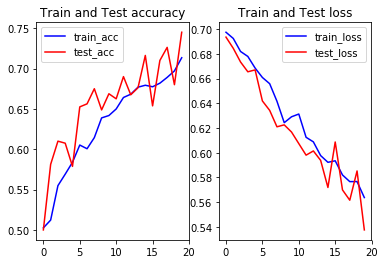

In [98]:
plot_training(history_ft)

In [104]:
# 用训练好的模型来预测新样本
from PIL import Image
from keras.preprocessing import image
def predict(model, img_path, target_size):
    img=Image.open(img_path) # 加载图片
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img) 
    x *=1./255 # 相当于ImageDataGenerator(rescale=1. / 255)
    x = np.expand_dims(x, axis=0) # 调整图片维度
    preds = model.predict(x) # 预测
    return preds[0]


In [105]:
predict(model,'E:\PyProjects\DataSet\FireAI\DeepLearning/FireAI005/cat11.jpg',(IMG_W,IMG_H))

array([0.14361556], dtype=float32)

In [106]:
predict(model,'E:\PyProjects\DataSet\FireAI\DeepLearning//FireAI005/dog4.jpg',(IMG_W,IMG_H))

array([0.9942463], dtype=float32)

In [107]:
predict(model,'E:\PyProjects\DataSet\FireAI\DeepLearning//FireAI005/dog2.jpg',(IMG_W,IMG_H))

array([0.7145583], dtype=float32)

In [119]:
# 预测一个文件夹中的所有图片
new_sample_gen=ImageDataGenerator(rescale=1. / 255)
newsample_generator=new_sample_gen.flow_from_directory(
        'E:\PyProjects\DataSet\FireAI\DeepLearning',
        target_size=(IMG_W, IMG_H),
        batch_size=16,
        class_mode=None,
        shuffle=False)
predicted=model.predict_generator(newsample_generator)
print(predicted)

Found 4 images belonging to 2 classes.
[[0.14361556]
 [0.5149474 ]
 [0.71455824]
 [0.9942463 ]]


In [120]:
# 模型保存
# model.save_weights('E:\PyProjects\DataSet\FireAI\DeepLearning//FireAI005/FireAI005_Model.h5') # 这个只保存weights，不保存模型的结构
model.save('E:\PyProjects\DataSet\FireAI\DeepLearning//FireAI005/FireAI005_Model2.h5') # 对于一个完整的模型，应该要保存这个

In [123]:
# 模型的加载，预测
from keras.models import load_model
saved_model=load_model('E:\PyProjects\DataSet\FireAI\DeepLearning//FireAI005/FireAI005_Model2.h5')

In [124]:
predicted=saved_model.predict_generator(newsample_generator)
print(predicted) # saved_model的结果和前面的model结果一致，表面模型正确保存和加载

[[0.14361556]
 [0.5149474 ]
 [0.71455824]
 [0.9942463 ]]
